# Genesis4 FODO Scan Model

This is a variation on the original FODO scan notebook, using more complicated objects to automate some behavior. 

In [1]:
import warnings
from dataclasses import dataclass
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np

from genesis.version4 import Genesis4, MainInput
import genesis.version4 as g4

%config InlineBackend.figure_format = 'retina'

# Ignore MPI warnings
warnings.filterwarnings("ignore")

# Lattice

These are the same parameters as the [Genesis4 SASE Benchmark](https://github.com/svenreiche/Genesis-1.3-Version4/blob/dev/benchmark/Benchmark1-SASE/Aramis.lat). The lattice is created here in code.

Note that the FODO cell length is 9.5 m, and there are 13 cells, for a total length of 123.5 m.

In [2]:
def make_fodo(
    Lcell=9.5,
    kL=None,
    lambdau=15e-3,
    Ltot=150,
    Lpad=0.685 / 2,  # Will be adjusted slightly to make Lcell exact
    Lquad=0.08,
    aw=0.84853,
):
    if kL is None:
        #  Optimal for flat beam
        kL = 1 / (sqrt(2) * Lcell / 2)

        # Optimal for round beam (90 deg phase advance)
        # k1L_optimal = 2*sqrt(2) / Lcell

    k1 = kL / Lquad

    # Length for single wiggler
    Lwig = (Lcell - 4 * Lpad - 2 * Lquad) / 2
    nwig = round(Lwig / lambdau)

    # Set padding exactly
    Lwig = lambdau * nwig
    Lpad = round((Lcell - 2 * Lwig - 2 * Lquad) / 4, 9)

    ncell = round(Ltot // Lcell)

    return g4.Lattice(
        elements={
            "D1": g4.Drift(L=Lpad),
            "D2": g4.Drift(L=Lpad),
            # k1*L = kL
            "QF": g4.Quadrupole(L=Lquad, k1=k1),
            "QD": g4.Quadrupole(L=Lquad, k1=-k1),
            "UND": g4.Undulator(lambdau=lambdau, nwig=nwig, aw=aw),
            "FODO": g4.Line(
                elements=["UND", "D1", "QF", "D2", "UND", "D1", "QD", "D2"]
            ),
            "LAT": g4.Line(elements=["FODO"] * ncell),
        }
    )


print(make_fodo(lambdau=30e-3, Lcell=9.5))

Lattice(
  elements={
    'D1': Drift(L=0.34),
    'D2': Drift(L=0.34),
    'QF': Quadrupole(L=0.08, k1=1.860807318911967),
    'QD': Quadrupole(L=0.08, k1=-1.860807318911967),
    'UND': Undulator(aw=0.84853, lambdau=0.03, nwig=133),
    'FODO': Line(elements=['UND', 'D1', 'QF', 'D2', 'UND', 'D1', 'QD', 'D2']),
    'LAT': Line(
      elements=[
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
        'FODO',
      ],
    ),
  },
)


In [3]:
def Krof(*, lambdar, lambdau, gamma):
    """
    K to make lambdar resonant
    """
    Ksq = 2 * (2 * gamma**2 * lambdar / lambdau - 1)
    if Ksq <= 0:
        raise ValueError(
            f"No resonance available, lambdau must be < {2 * gamma**2 * lambdar * 1e3:0.1f}1e-3 m"
        )

    return sqrt(Ksq)


Krof(lambdar=1e-10, lambdau=25e-3, gamma=11357.82) / sqrt(2)

0.17888711865084084

In [4]:
@dataclass
class FODOModel:
    # Lengths
    Lcell: float = 9.5
    Ltot: float = 125
    Lquad: float = 0.08
    Lpad: float = 0.685 / 2

    kL: float = None  # Will be picked automatically

    lambdar: float = 1e-10
    lambdau: float = 15e-3
    gamma: float = 11357.82

    current: float = 3000
    delgam: float = 1.0
    norm_emit_x: float = 0.4e-6
    norm_emit_y: float = 0.4e-6

    nproc = 0  # Auto-select

    seed: int = None  # None will pick a random seed

    def make_lattice(self):
        """Returns the Lattice instance, setting aw for resonance."""
        aw = Krof(lambdar=self.lambdar, lambdau=self.lambdau, gamma=self.gamma) / sqrt(
            2
        )
        return make_fodo(
            Lcell=self.Lcell,
            kL=self.kL,
            lambdau=self.lambdau,
            Ltot=self.Ltot,
            Lpad=self.Lpad,  # Will be adjusted
            Lquad=self.Lquad,
            aw=aw,
        )

    def make_genesis(self):
        if self.seed is None:
            seed = np.random.randint(0, 1e10)
        else:
            seed = self.seed

        input = MainInput(
            namelists=[
                g4.Setup(
                    rootname="Benchmark",
                    beamline="LAT",
                    lambda0=self.lambdar,
                    gamma0=self.gamma,
                    delz=0.045,
                    seed=seed,
                    shotnoise=False,
                    beam_global_stat=True,
                    field_global_stat=True,
                ),
                g4.LatticeNamelist(zmatch=self.Lcell),
                g4.Field(
                    power=5000,
                    dgrid=0.0002,
                    ngrid=255,
                    waist_size=3e-05,
                ),
                g4.Beam(
                    current=self.current,
                    delgam=self.delgam,
                    ex=self.norm_emit_x,
                    ey=self.norm_emit_y,
                ),
                g4.Track(zstop=self.Ltot),
            ]
        )
        lattice = self.make_lattice()
        return Genesis4(input, lattice, verbose=True)

    def run(self):
        G = self.make_genesis()
        G.nproc = self.nproc
        G.run()
        return G


fodo_model = FODOModel(Ltot=20)

In [5]:
G = fodo_model.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpi4edz4ru
Setting use_mpi = True because nproc = 12
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpi4edz4ru
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 12 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Fri Aug 23 15:33:35 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 9.8922
   alphax    : -0.756992
   phix (deg): 41.1658
   betay (m) : 17.2567
   alphay    : 1.29774
   phiy (deg): 44.1394
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysi

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

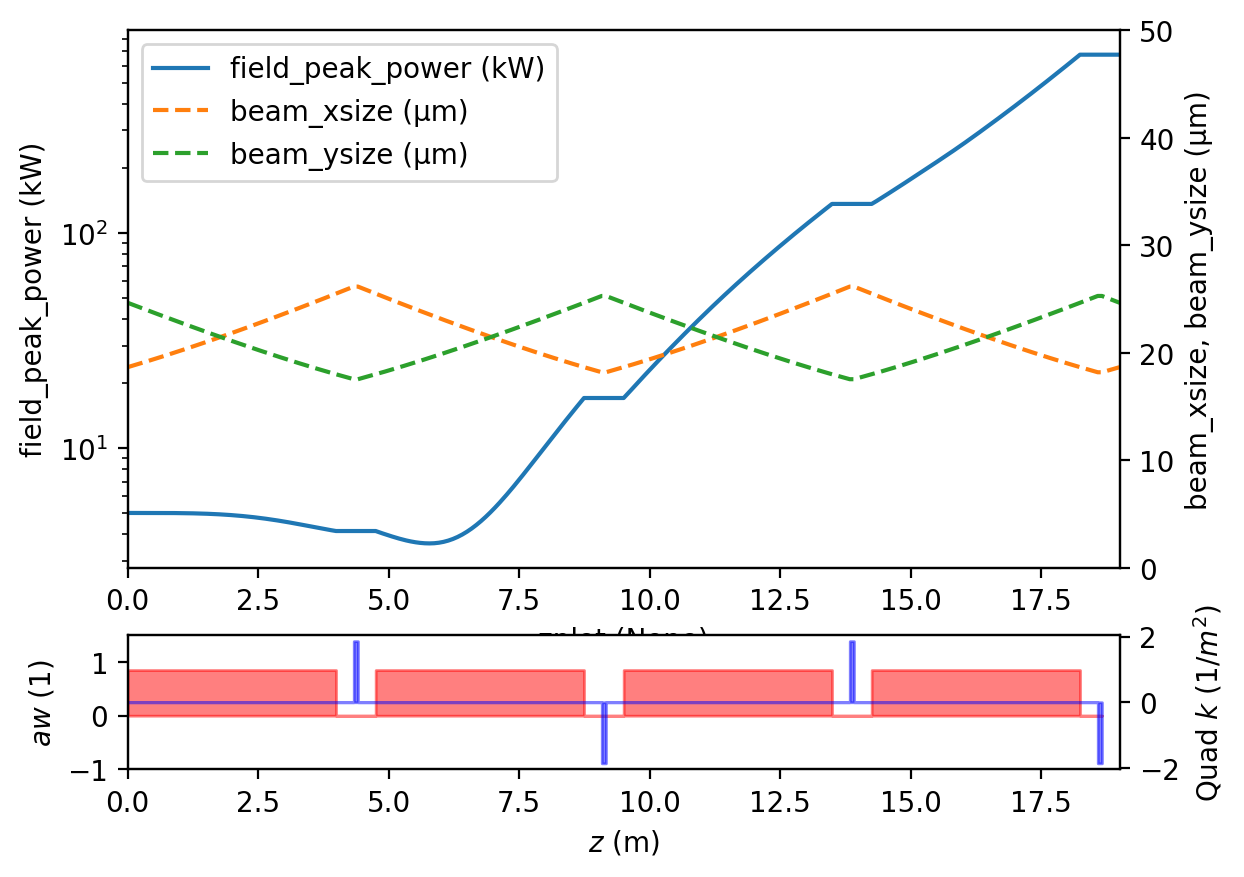

In [6]:
G.plot(
    "field_peak_power", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, 50e-6)
)

# Run1 function

Make a simple function to run a complete simulation and return a `Genesis4` object.

In [7]:
def run1(kL):
    G = FODOModel(kL=kL).run()
    return G


G2 = run1(0.136)  # = 1.7 * .08

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp41sp0ts8
Setting use_mpi = True because nproc = 12
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp41sp0ts8
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 12 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Fri Aug 23 15:33:41 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 11.1501
   alphax    : -0.775418
   phix (deg): 37.4688
   betay (m) : 18.1031
   alphay    : 1.24086
   phiy (deg): 40.6908
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analys

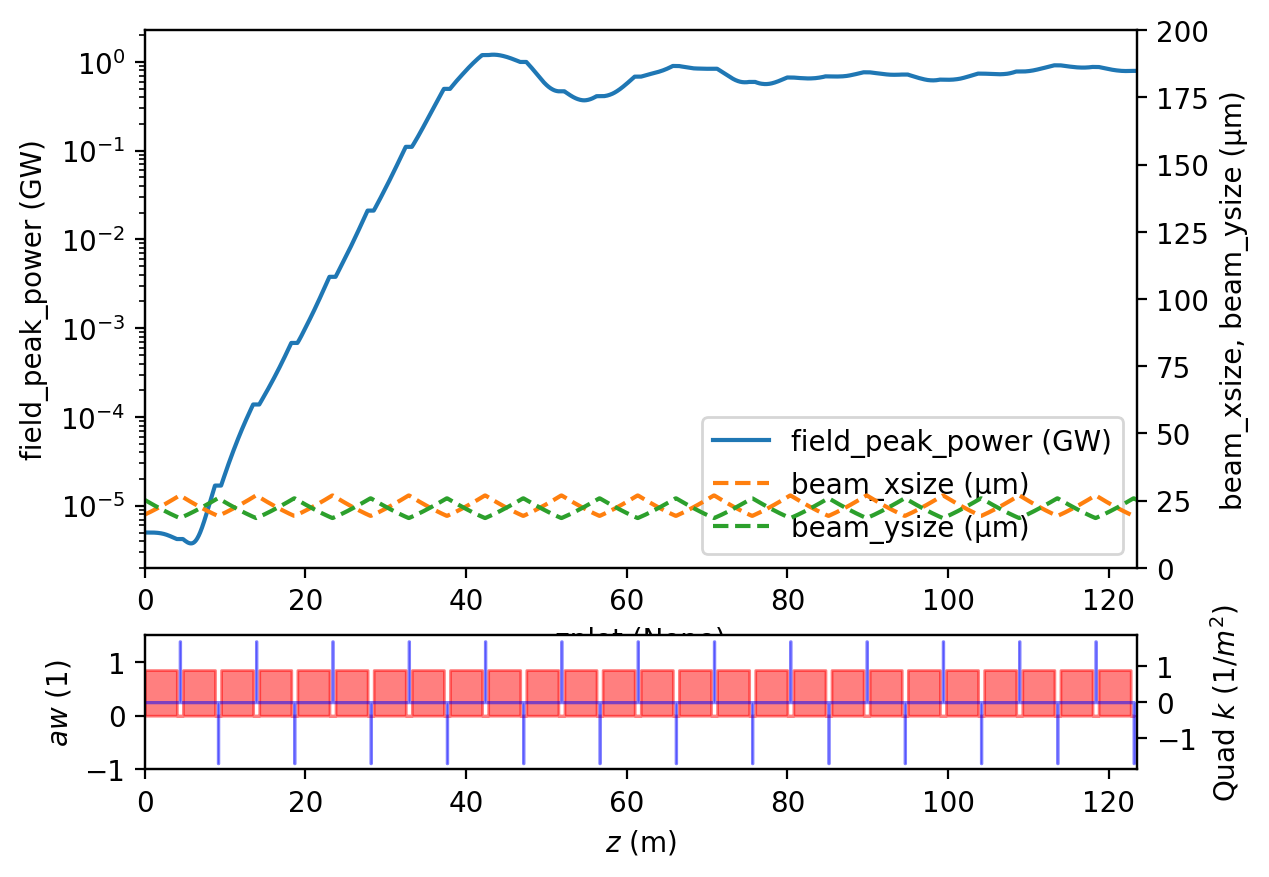

In [8]:
G2.plot(
    "field_peak_power", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, 200e-6)
)

# Scan kL

Now scan use this function to scan various quadrupole k1. Note that Genesis4 is doing matching internally with `zmatch` in the input.

In [9]:
%%time
kLlist = np.linspace(0.1, 0.4, 10)
Glist = [run1(kL) for kL in kLlist]

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp6at8y_fz
Setting use_mpi = True because nproc = 12
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp6at8y_fz
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 12 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Fri Aug 23 15:34:08 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 16.405
   alphax    : -0.829624
   phix (deg): 27.3204
   betay (m) : 21.3934
   alphay    : 1.07148
   phiy (deg): 31.5325
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysi

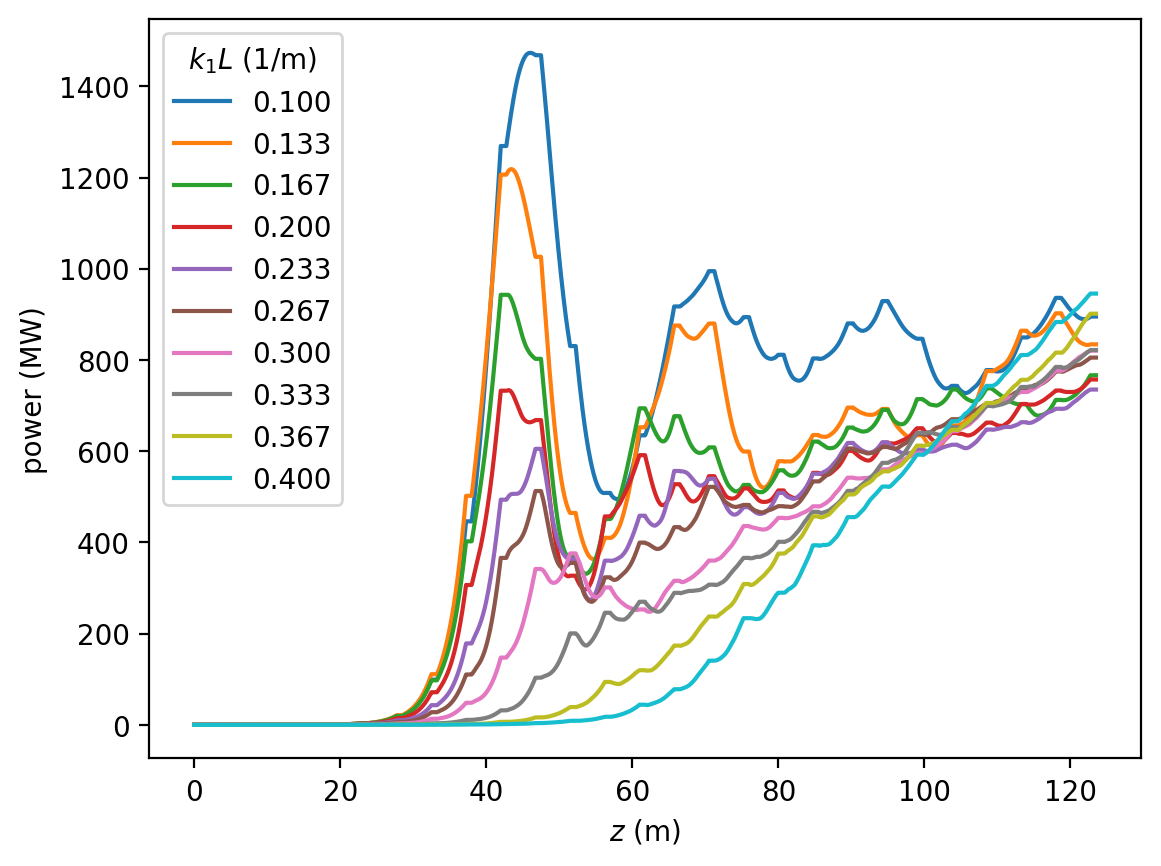

In [10]:
fig, ax = plt.subplots()
for k, g in zip(kLlist, Glist):
    x = g.stat("zplot")
    y = g.stat("field_peak_power")
    ax.plot(x, y / 1e6, label=f"{k:0.3f}")
# ax.set_yscale('log')
ax.set_xlabel(r"$z$ (m)")
ax.set_ylabel("power (MW)")
plt.legend(title=r"$k_1L$ (1/m)")

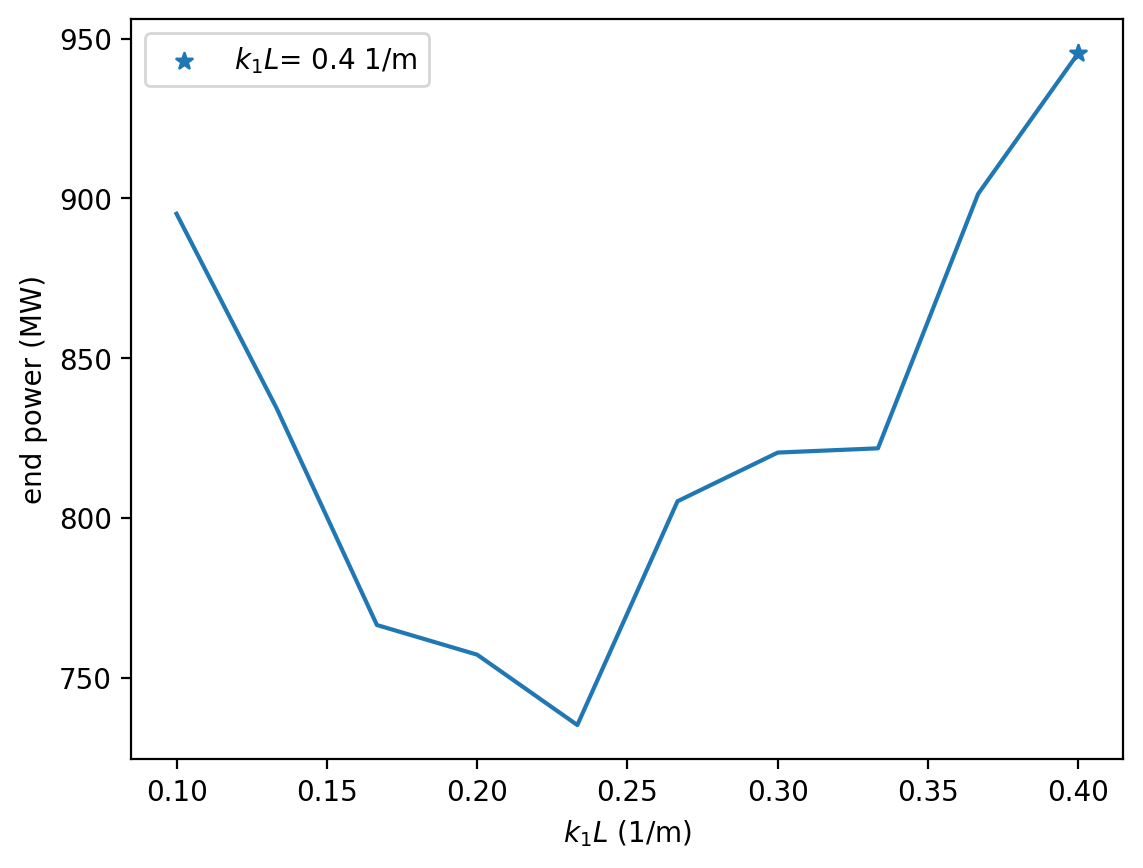

In [11]:
fig, ax = plt.subplots()
y = np.array([g.stat("field_peak_power")[-1] for g in Glist])
ixbest = y.argmax()
Gbest = Glist[ixbest]
kbest = kLlist[ixbest]
ybest = y[ixbest]
ax.plot(kLlist, y / 1e6)
ax.scatter(kbest, ybest / 1e6, marker="*", label=rf"$k_1L$= {kbest:0.1f} 1/m")
ax.set_ylabel("end power (MW)")
ax.set_xlabel(r"$k_1L$ (1/m)")
plt.legend()

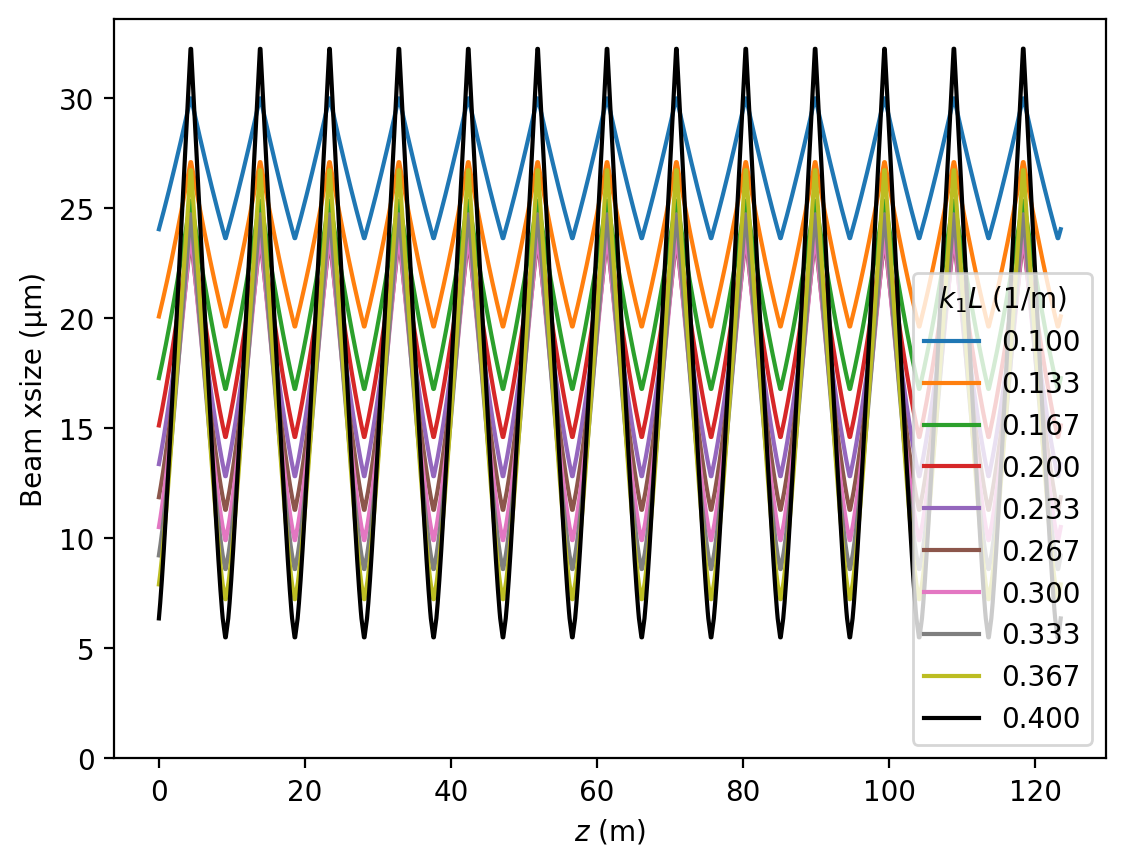

In [12]:
fig, ax = plt.subplots()
for k, g in zip(kLlist, Glist):
    x = g.stat("zplot")
    y = g.stat("beam_xsize")
    if k == kbest:
        color = "black"
    else:
        color = None
    ax.plot(x, y * 1e6, label=f"{k:0.3f}", color=color)

ax.set_xlabel(r"$z$ (m)")
ax.set_ylabel("Beam xsize (µm)")
ax.set_ylim(0, None)
plt.legend(title=r"$k_1L$ (1/m)");

# Scan lambdau

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpwbpvkxx_
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpwbpvkxx_
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Fri Aug 23 15:38:43 2024

MPI-Comm Size: 1 node

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 9.89977
   alphax    : -0.757787
   phix (deg): 41.1658
   betay (m) : 14.1443
   alphay    : 1.05518
   phiy (deg): 54.2739
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculation: 10% done
  Calculation:

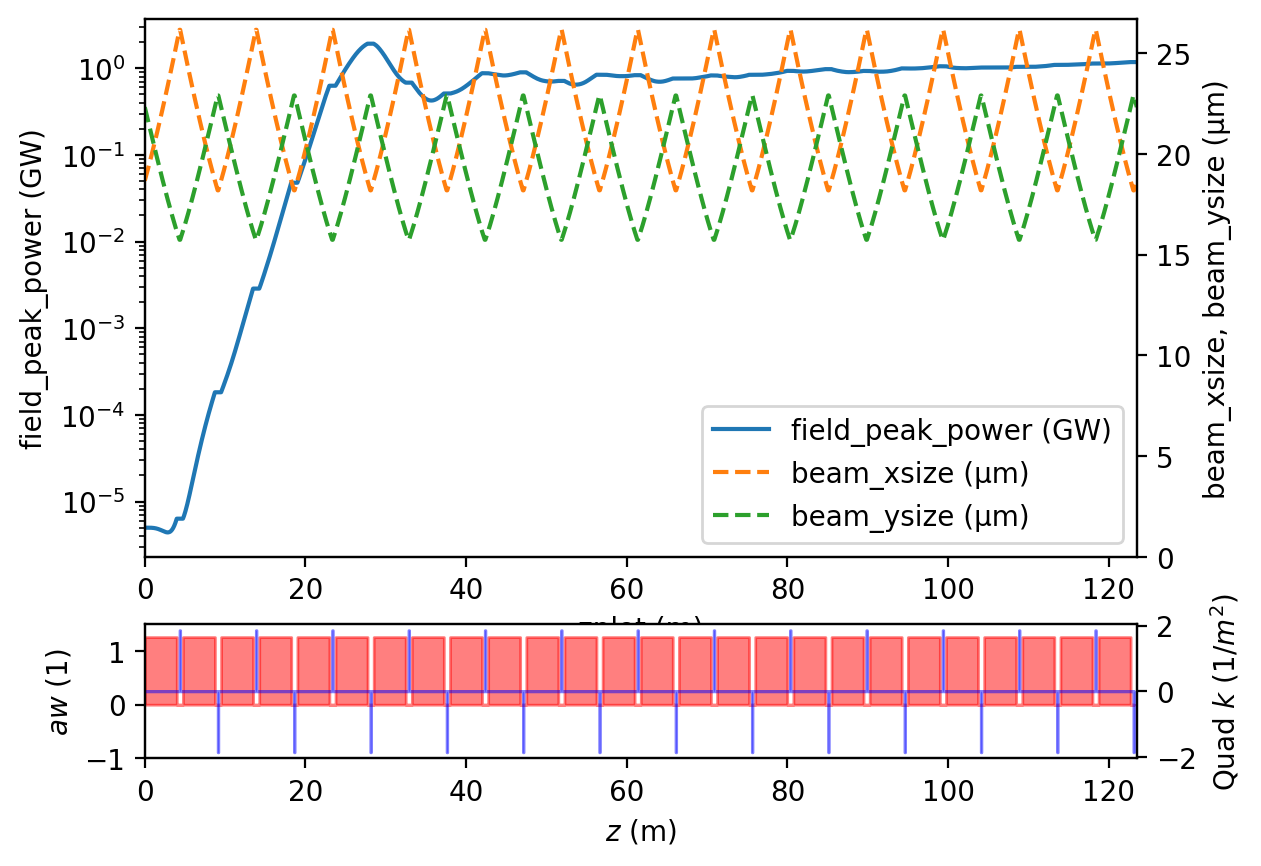

In [13]:
def run1(lambdau):
    p = {}
    p["lambdau"] = lambdau
    G = FODOModel(**p).make_genesis()
    G.run()
    return G


G2 = run1(10e-3)
G2.plot(
    "field_peak_power", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, None)
)

In [14]:
%%time
lambdaulist = np.linspace(10e-3, 25e-3, 10)
Glist = [run1(lambdau) for lambdau in lambdaulist]

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpfpw110q3
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpfpw110q3
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Fri Aug 23 15:38:54 2024

MPI-Comm Size: 1 node

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 9.89977
   alphax    : -0.757787
   phix (deg): 41.1658
   betay (m) : 14.1443
   alphay    : 1.05518
   phiy (deg): 54.2739
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculation: 10% done
  Calculation:

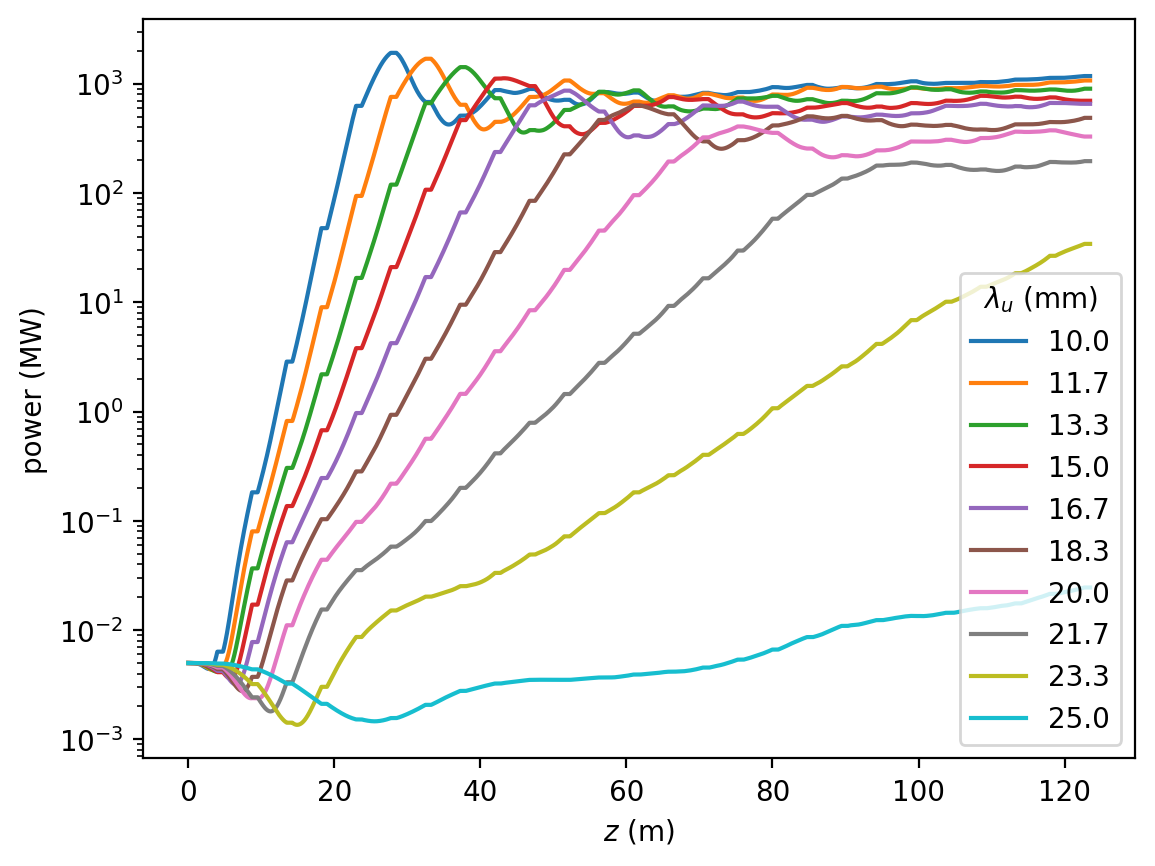

In [15]:
fig, ax = plt.subplots()
for k, g in zip(lambdaulist, Glist):
    x = g.stat("zplot")
    y = g.stat("field_peak_power")
    ax.plot(x, y / 1e6, label=f"{k * 1e3:0.1f}")
ax.set_yscale("log")
ax.set_xlabel(r"$z$ (m)")
ax.set_ylabel("power (MW)")
plt.legend(title=r"$\lambda_u$ (mm)")